In [49]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [2]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.75, random_state=2)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [3]:
pd.DataFrame(X, columns=feature_names).describe()

,x1,x2
count,300.000000,300.000000
mean,-2.920353,-3.233006
std,92.872732,101.251122
min,-188.394649,-251.957930
25%,-79.144230,-74.866120
50%,-15.527081,-6.890370
75%,69.936232,60.078319
max,332.353481,316.096597


In [4]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

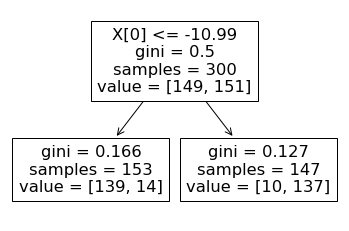

In [5]:
from sklearn.tree import plot_tree
plot_tree(tree);

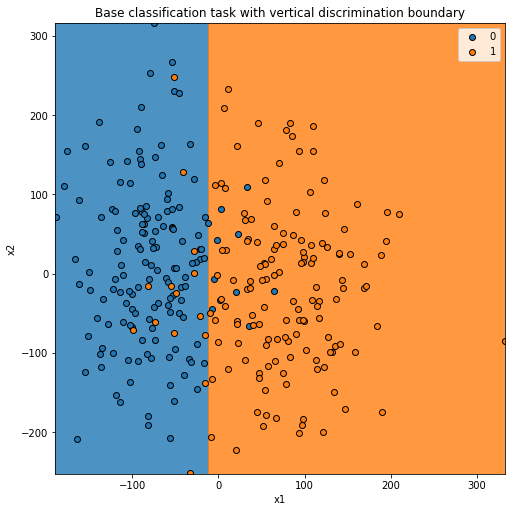

In [6]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with vertical discrimination boundary', feature_names,
                       predict=tree.predict, class_names=tree.classes_,
                       fig=fig, ax=ax)

In [7]:
clf_a = tree

In [8]:
from sklearn.dummy import DummyClassifier
clf_b = DummyClassifier(strategy='uniform', random_state=0)
clf_b.fit(X, y)

DummyClassifier(random_state=0, strategy='uniform')

In [9]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

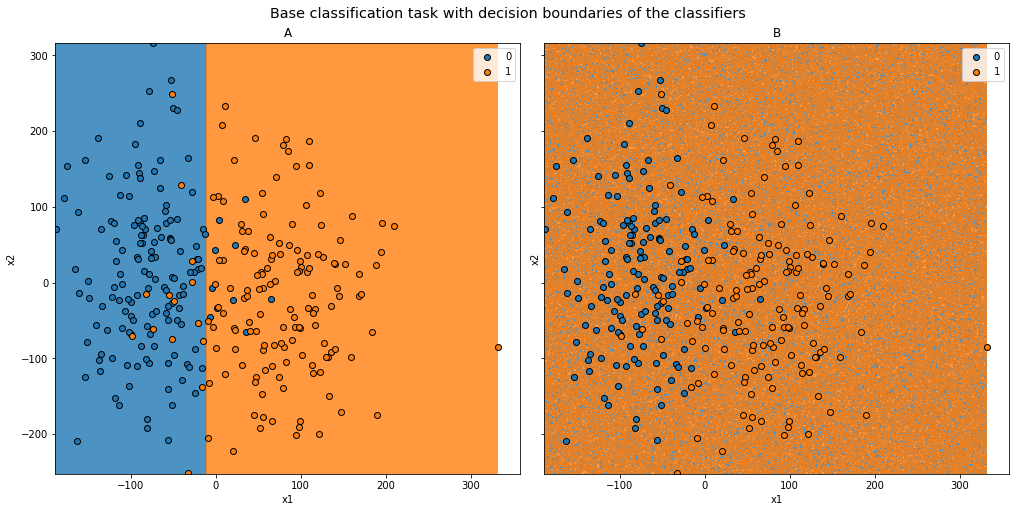

In [10]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', mesh_step_size=1)

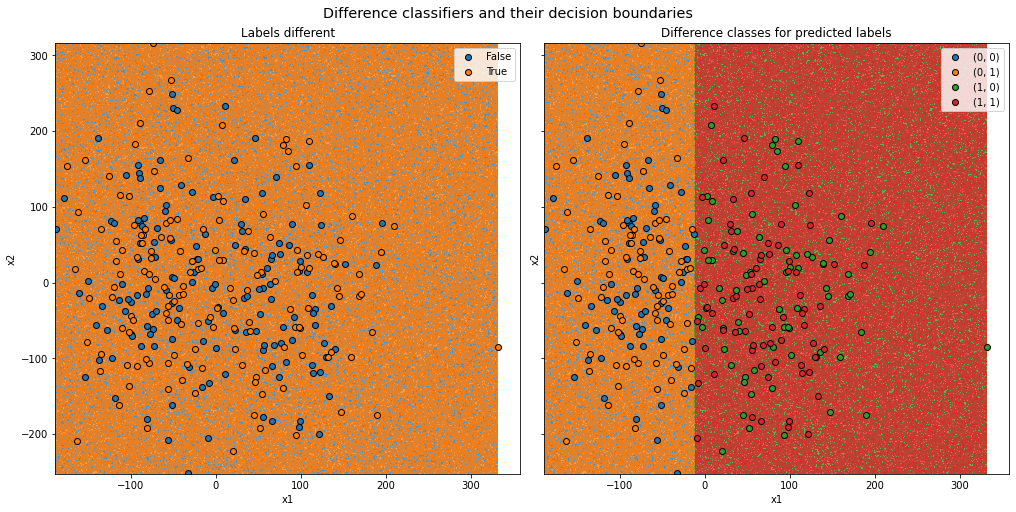

In [11]:
comparer.plot_decision_boundaries(X, mesh_step_size=1)

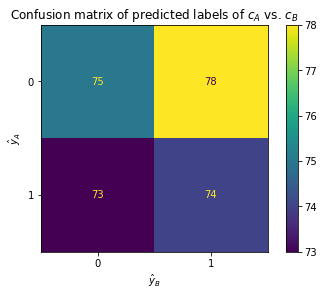

In [12]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [13]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 5.53 s, sys: 96.5 ms, total: 5.63 s
Wall time: 5.88 s


In [14]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 2), (0,), (0,))

In [15]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

A bases its decisions solely on x1, to B x2 is more important than x1.

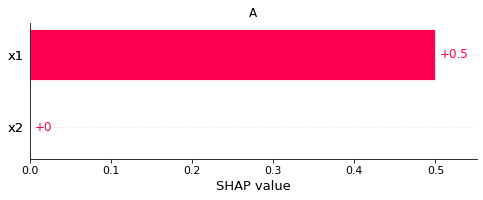

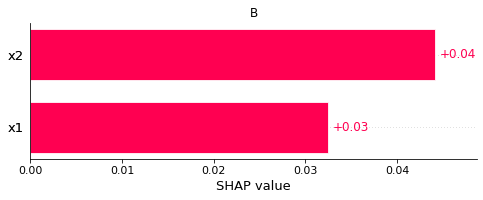

In [16]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [18]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [19]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.labels[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.labels[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

For A we see that low feature values decrease the outcome, high feature values increase it. For B, the effect is constant (negative) and close to zero.

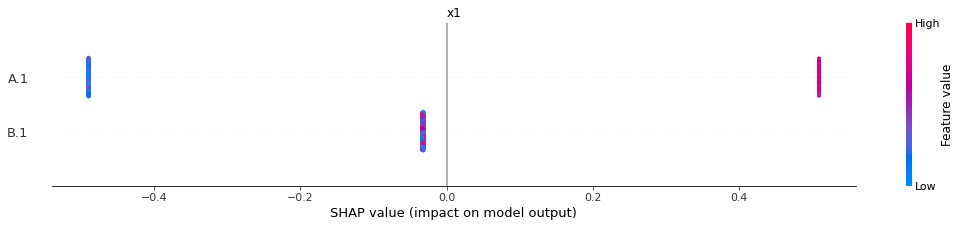

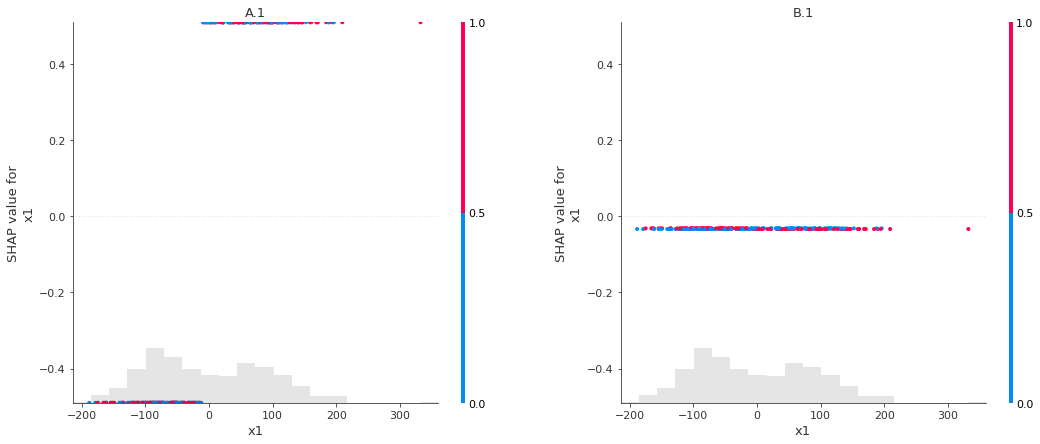

In [20]:
plot_next_feature()

To A, the effect of x2 is constant (0). To B, the effect is constant but now we can see the two groups, also present in x1.

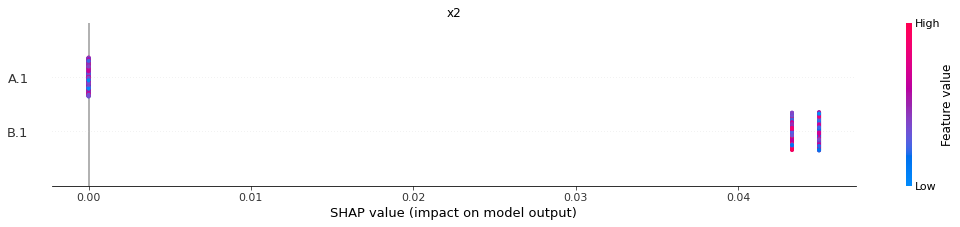

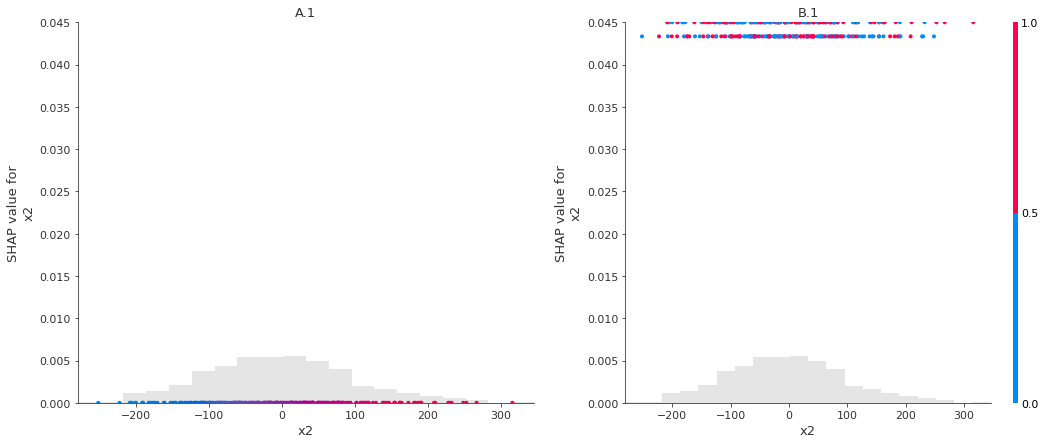

In [21]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

For the differences, x1 is more important than x2.

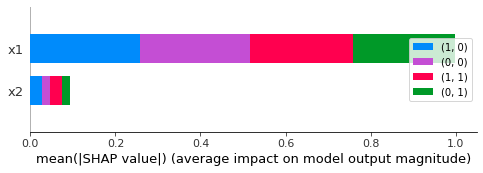

In [22]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

The classes are nearlly equally important. We will stick to the original ordering.

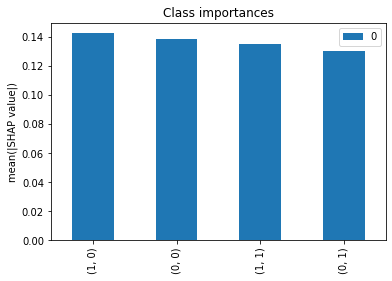

In [27]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [28]:
class_order = np.sort(class_order)

In [39]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order])
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order], color=is_pred_diff)
it = iter(feature_order)

Low feature values increase the effect of $(0,0)$ and $(0,1)$, high feature values increase the effect of $(1,0)$ and $(1,1)$.

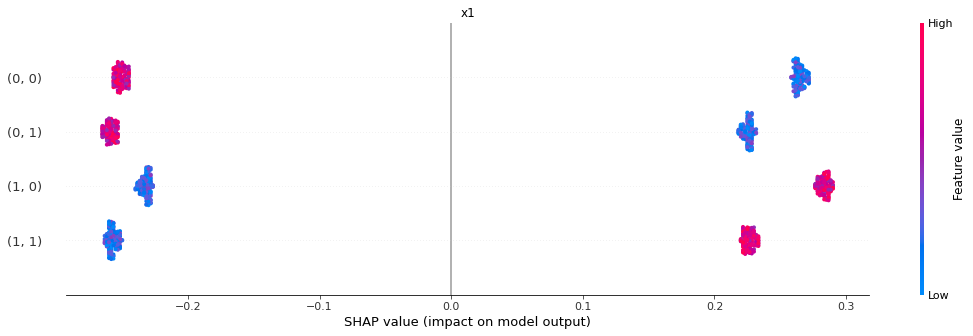

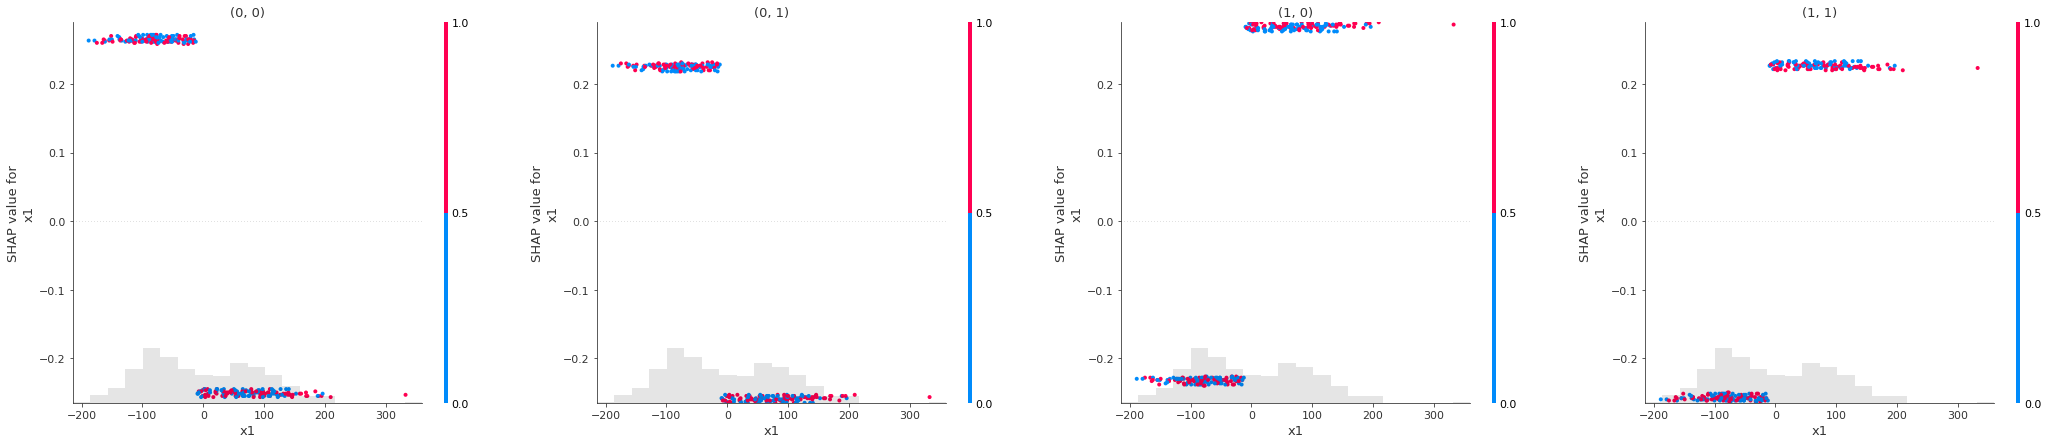

In [40]:
plot_next_feature()

We can see only constant effects for each class, separated in two groups each.

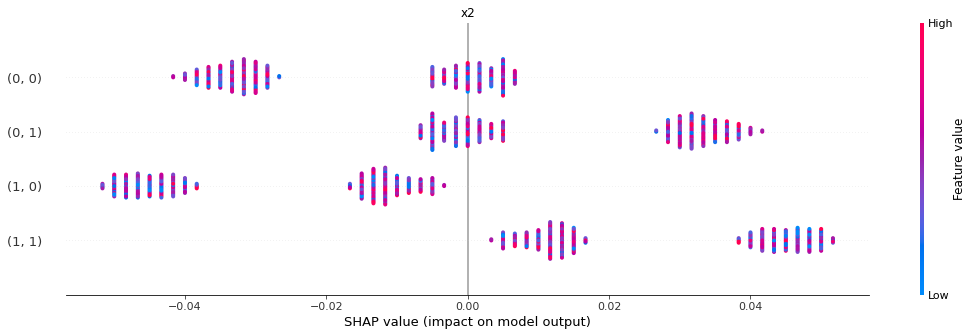

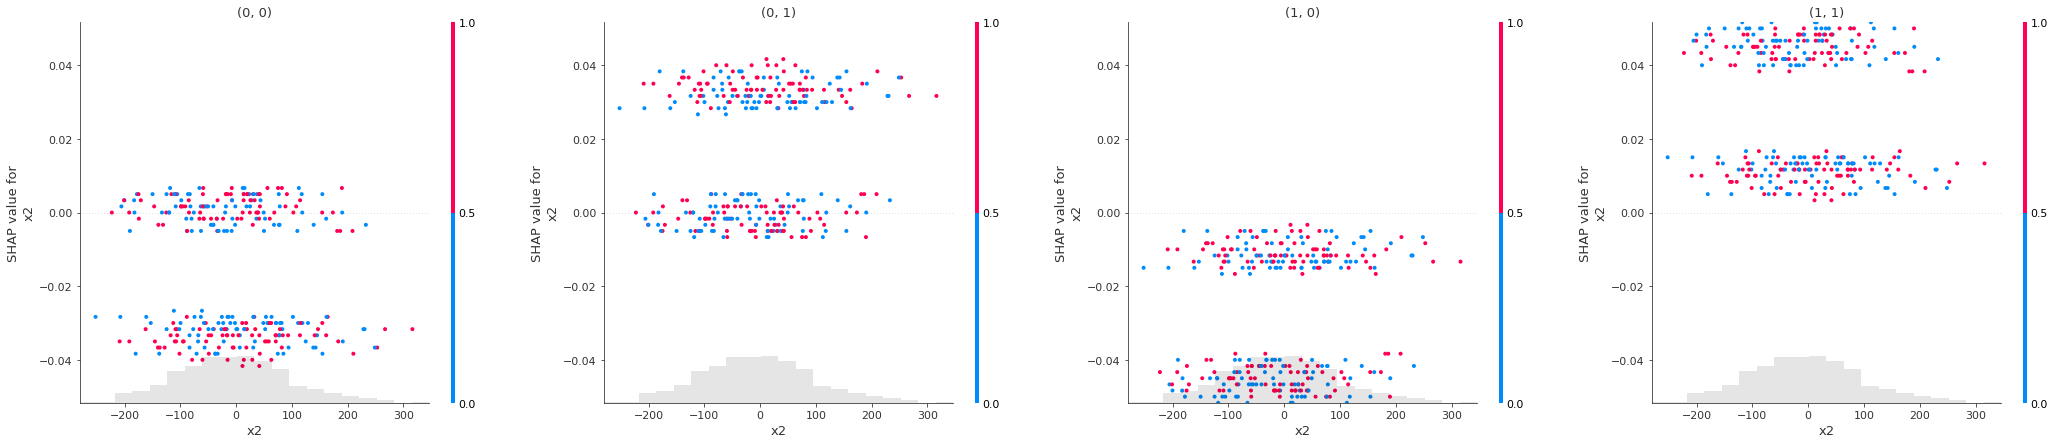

In [41]:
plot_next_feature()

# Local Explanations

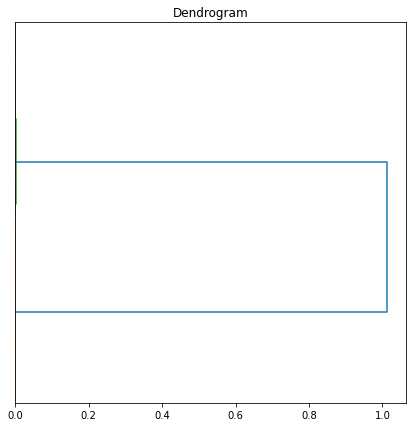

In [31]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

Using $n=2$ we get separate pairs of classes. If we would increase the number, at $n=3$ the second cluster is split and at $m=4$ the first.

In [32]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=2)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,68,79
c2,71,82,0,0


In [64]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

## 1. Cluster

These feature value distributions are different locally compared to the global level:
- x1 reaches only from -9 upwards
- x2 reaches only from -222 to 232

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x1 was lower, the effect would shift towards $(0,0)$ and $(0,1)$: Setting it to -100 changes all predictions of instances originally classified $(1,0)$ to $(0,0)$, and all predictions of instances originally classified $(1,1)$ to $(0,1)$.

Locally, only constant effects are visible within the cluster.

In [65]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,68,79


In [37]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,147.000000,147.000000
mean,77.699309,-16.152181
std,56.182196,96.909058
min,-9.559195,-222.734129
25%,35.750019,-84.648712
50%,74.523892,-17.628614
75%,112.946973,40.921563
max,332.353481,232.639090


In [42]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = -100
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",NaN,68.0
"(1, 0)",68.0,NaN


,before,after
"(0, 1)",NaN,79.0
"(1, 1)",79.0,NaN


### SHAP-based Difference Classifier Explanations

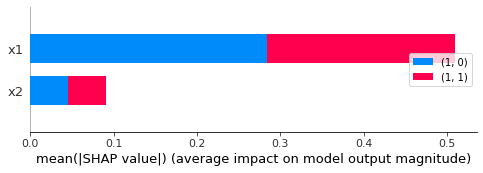

In [66]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

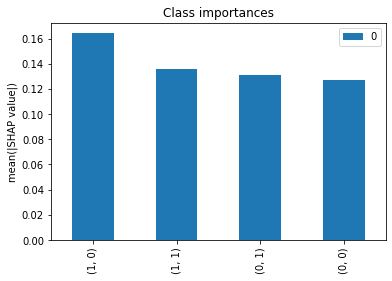

In [67]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [68]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

Within the cluster, there are only constant effects visible.

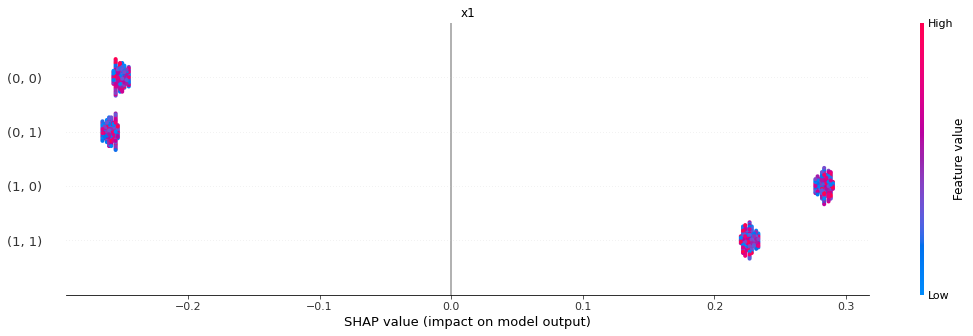

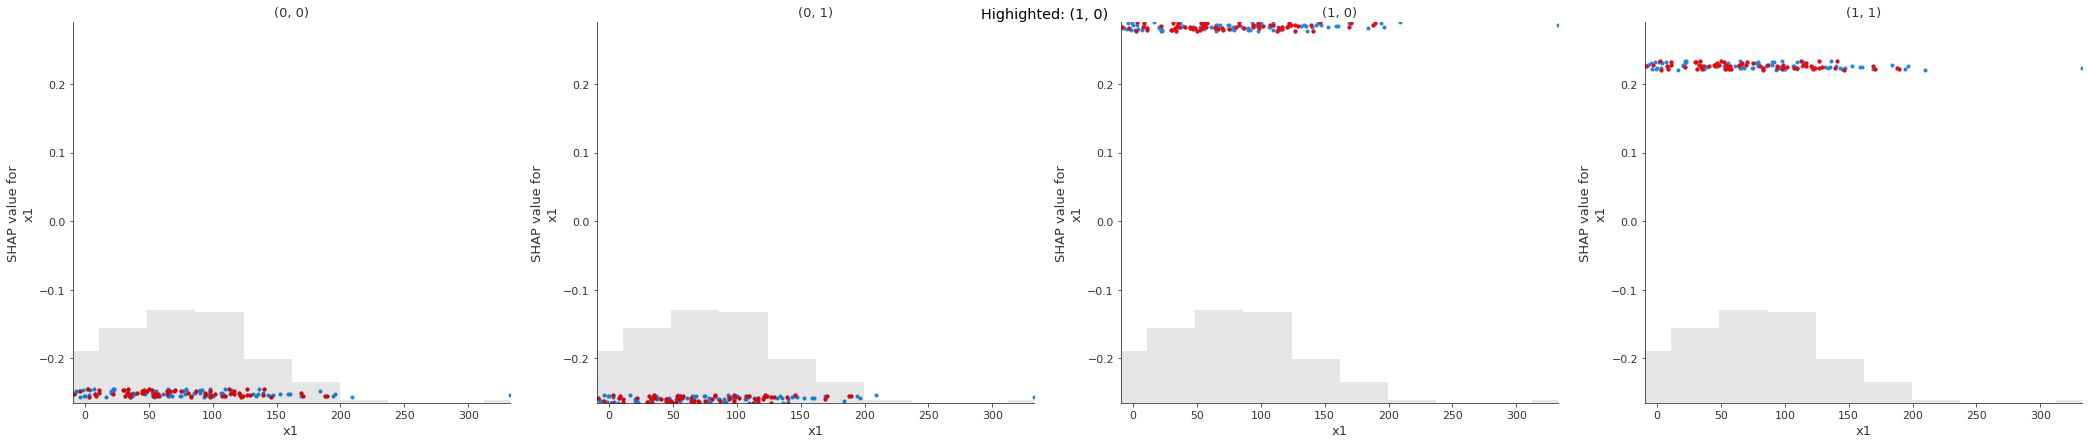

In [69]:
plot_next_feature()

Now we can see, why there were two groups in the global plots: this cluster is one of them.

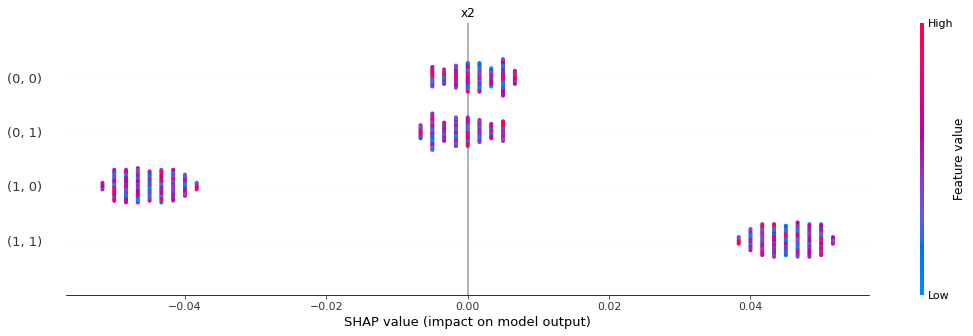

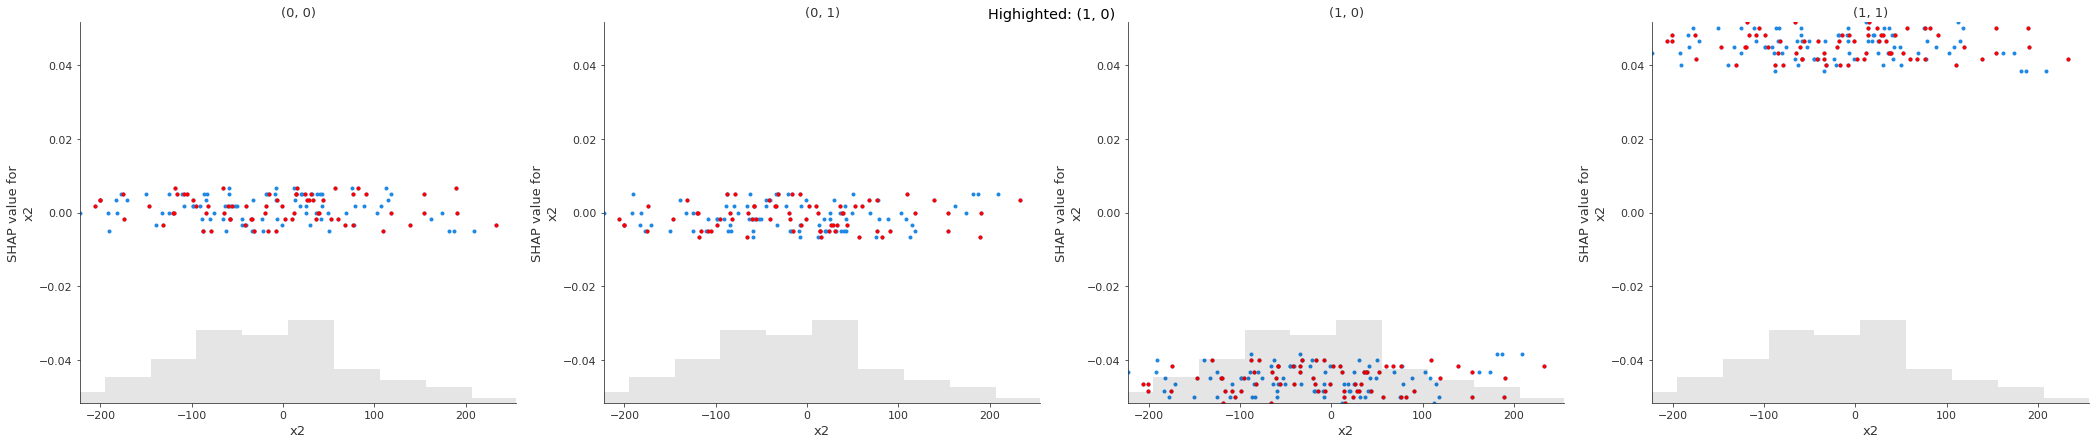

In [70]:
plot_next_feature()

### diro2c

diro2c did not find any instances below $x1=-9$, that are classified $(1,0)$.

In [50]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [51]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 22.9 s, sys: 235 ms, total: 23.1 s
Wall time: 23.6 s


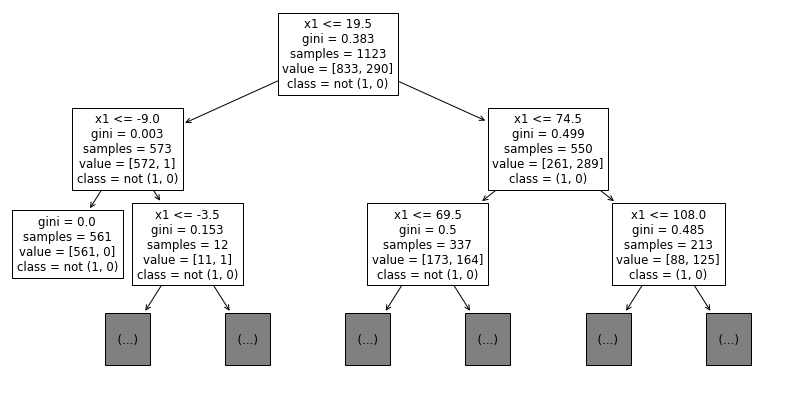

In [54]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=2)

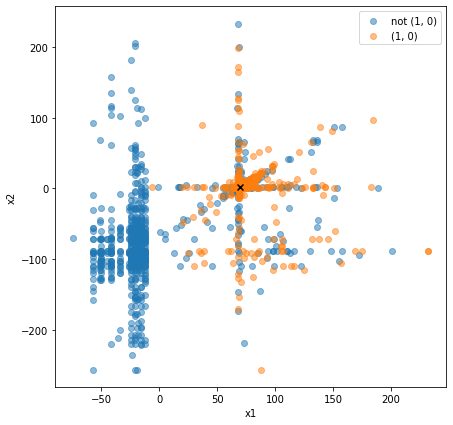

In [55]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)

## 2. Cluster

These feature value distributions are different locally compared to the global level:
- x1 reaches only from -151 to -16
- x2 reaches only from -180 to 248

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x1 was higher, the effect would shift towards $(1,1)$ and $(1,0)$: Setting it to 0 changes all predictions of instances originally classified $(0,1)$ to $(1,1)$, and all predictions of instances originally classified $(0,0)$ to $(1,0)$.

Locally, only constant effects are visible within the cluster.

In [71]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c2,12,17,0,0


In [73]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,29.000000,29.000000
mean,-76.801684,15.392928
std,33.423896,101.262946
min,-151.469210,-180.071604
25%,-92.221317,-56.449343
50%,-82.813766,11.405388
75%,-51.736118,74.759894
max,-16.033428,248.718458


In [74]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",12.0,NaN
"(1, 0)",NaN,12.0


,before,after
"(0, 1)",17.0,NaN
"(1, 1)",NaN,17.0


### SHAP-based Difference Classifier Explanations

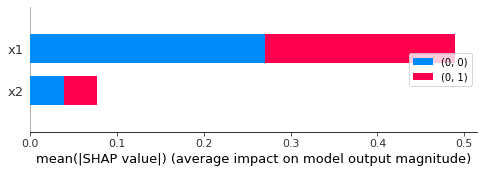

In [75]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

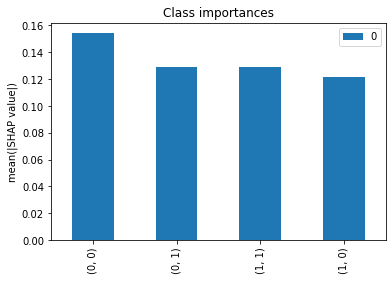

In [76]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [77]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

Within the cluster, there are only constant effects visible.

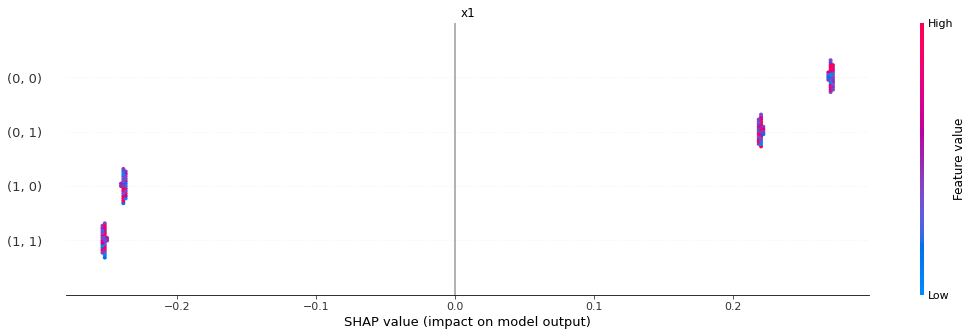

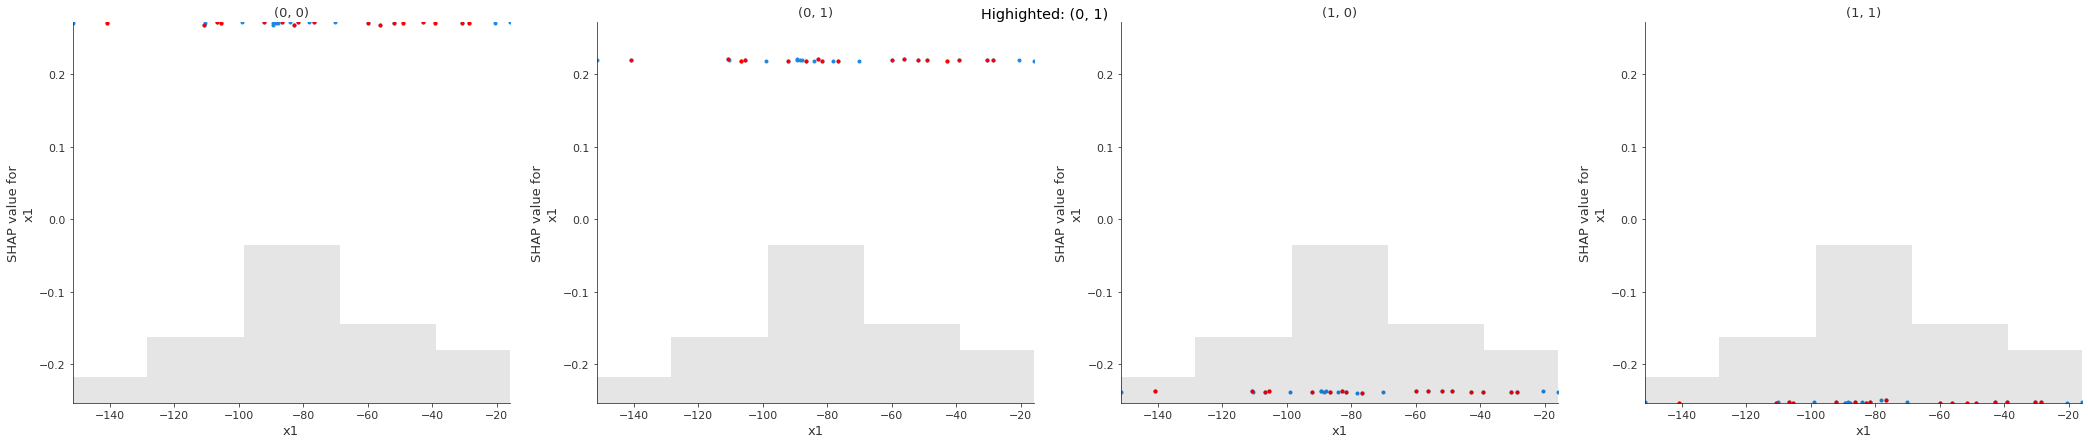

In [78]:
plot_next_feature()

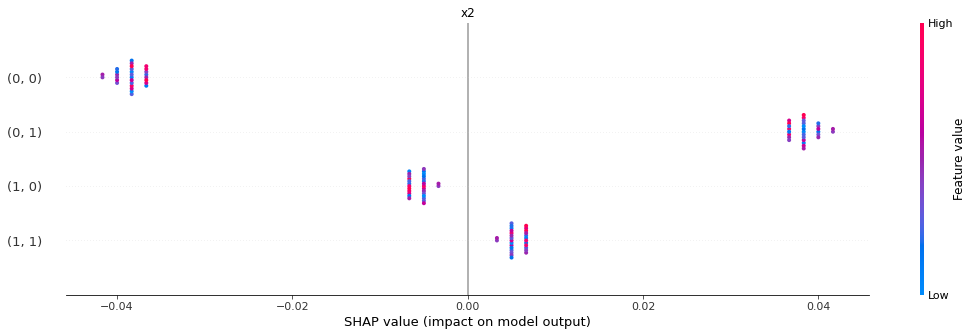

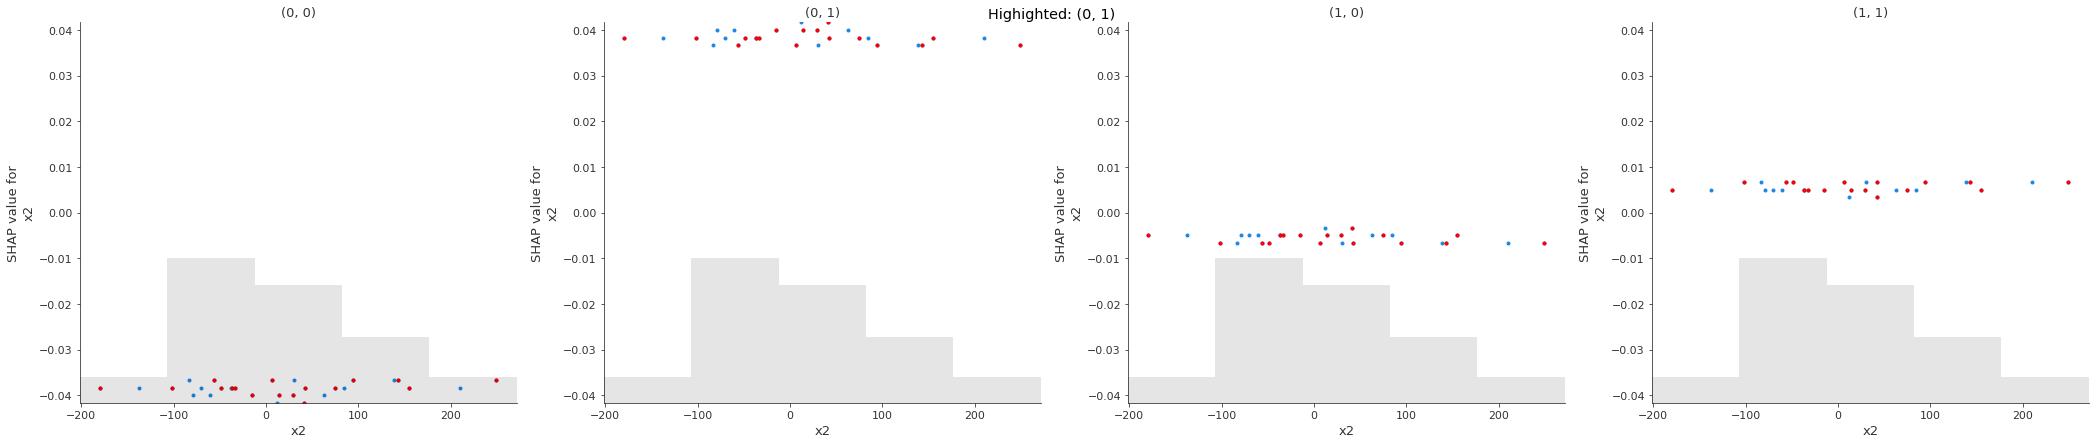

In [79]:
plot_next_feature()

### diro2c

diro2c did not sample enough in the upper part of x1, to find the real limit of class $(0,1)$. But -20.5 is close.

In [80]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [81]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 21.8 s, sys: 147 ms, total: 21.9 s
Wall time: 22.1 s


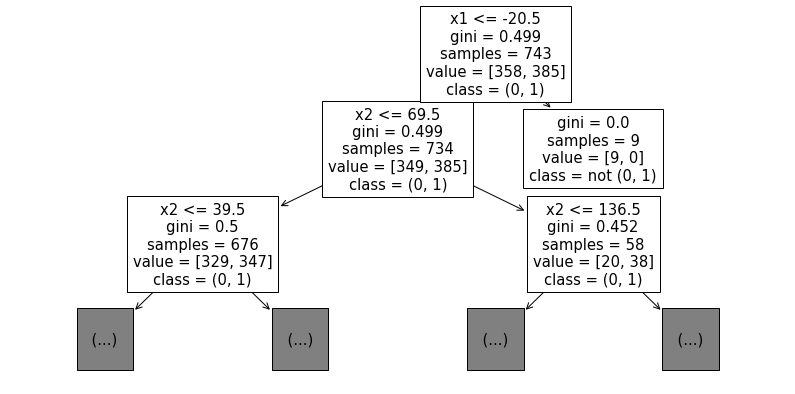

In [82]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation, max_depth=2)

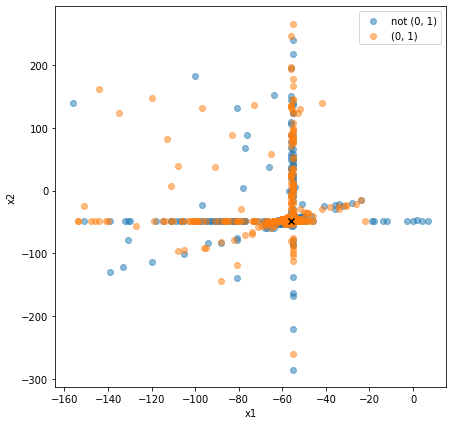

In [83]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)